In [2]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags, csr_matrix, kron
from scipy.linalg import solve_sylvester, schur, expm
from scipy.sparse.linalg import spsolve, cg
from scipy.integrate import quad
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import random
%config InlineBackend.figure_format = 'svg'

In [3]:
def plot_sol(X,Y,U):
    plt.figure(0)
#     ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(U, -1)
#     plt.contourf(X, Y, U)
    plt.imshow(U, extent=[0,1,0,1], origin='lower')
    plt.colorbar()
    plt.axis(aspect='image')
    plt.xlabel('x')
    plt.ylabel('y')
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('u')
#     ax.plot3D(xline, yline, zline)

def compute_err(U, U_exact):
    n = len(U)
    err_inf = 0
    err_sq = 0
    for i in range(0,n):
        for j in range(0,n):
            err_sq += np.absolute(U_exact[i][j] - U[i][j])**2
            if np.absolute(U_exact[i][j] - U[i][j]) > err_inf:
                err_inf = np.absolute(U_exact[i][j] - U[i][j])
        
    err_sq = (err_sq * h**2)**0.5
    return err_inf, err_sq


## Direct methods
- Kronecker product
- Scipy solver (uses Bartels-Stewart)
- Bartels-Stewart
- Similarity transformation (using numpy.linalg.eig)
- Similarity transformation (explicitly calculating eigs)
- Shifted system (algorithm 3 from computational methods for linear matrix equations)

In [4]:
def kron_prod_direct(T,F):
    n = len(F)
    start_time = time.time()
    F = np.reshape(F,-1)
    A = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n)) #A = I kron T + T^t kron I
    kron_time = time.time() - start_time
    U = spsolve(A, F) #Solve using scipy sparse solver
    end_time = time.time()
    solve_time = end_time - kron_time - start_time
    total_time = end_time - start_time
    timings = [kron_time, solve_time, total_time]
    U = np.reshape(U, (n,n)) #Reshape U to nxn for plotting/computing error
    return U, timings


def scipy_solver(T, F):
    start_time = time.time()
    U = solve_sylvester(T, T, F)
    end_time = time.time()
    total_time = end_time - start_time
    return U, total_time

def bartels_stewart(T, F):
    start_time = time.time()
    R, P = schur(T) #Compute Schur decomposition
    R_trans = R.transpose()
    schur_time = time.time() - start_time

    #Solve R^*V + VR = P^*FP for V
    V = np.empty([n,n])
    RHS = np.matmul(np.matmul(P.transpose(),F),P)
    for i in range(0,n):
        for j in range(0,n):
            sum1 = 0
            sum2 = 0
            
            for a in range(0,i-1):
                sum1 += R_trans[i][a]*V[a][j]
            for b in range(0,j-1):
                sum2 += V[i][b]*R[b][j]
                
            V[i][j] = (RHS[i][j] - sum1 - sum2)/(R_trans[i][i]+R[j][j])
    V_time = time.time() - schur_time - start_time
            
    U = np.matmul(np.matmul(P,V),P.transpose()) #Compute U=PVP^*
    end_time = time.time()
    solve_time = end_time - V_time - schur_time - start_time
    total_time = end_time - start_time
    timings = [schur_time, V_time, solve_time, total_time]
    return U, timings

def sim_trans(T, F):
    start_time = time.time()
    eigvals, eigvecs = np.linalg.eig(T) #Get eigenvalues and eigenvectors of T
    eig_time = time.time() - start_time
    diag = diags(eigvals, 0, shape=(n, n)).toarray() #Set eigenvalues as diagonal matrix
    P = eigvecs #Set basis matrix P, with columns as the eigenvectors
    diag_time = time.time() - eig_time - start_time
    F_hat = np.matmul(np.matmul(np.linalg.inv(P),F),P) #F_hat = P^-1 * F * P
    F_time = time.time() - diag_time - eig_time - start_time

    U_hat = np.empty([n,n]) #u_hat(i,j) = f(i,j) / eigval(i) + eigval(j)
    for i in range(0,n):
        for j in range(0,n):
            if (eigvals[i]!=0 or eigvals[j]!=0):
                U_hat[i][j] = F_hat[i][j] / (eigvals[i]+eigvals[j])
            else:
                U_hat[i][j] = 0

    U_time = time.time() - F_time - diag_time - eig_time - start_time
    U = np.matmul(np.matmul(P,U_hat),np.linalg.inv(P)) #U = P * U^hat * P^-1
    end_time = time.time()
    solve_time = end_time - U_time - F_time - diag_time - eig_time - start_time
    total_time = end_time - start_time
    timings = [eig_time, diag_time, F_time, U_time, solve_time, total_time]
    return U, timings

def sim_trans_explicit(T, F):
    start_time = time.time()
    eigvals = np.empty(n)
    eigvecs = np.empty([n,n])

    for i in range(0,n):
        eigvals[i] = (T[0][0] - T[0][0]*np.cos((i+1)*np.pi/(n+1)))
        for j in range(0,n):
            eigvecs[i][j] = np.sqrt(2/(n+1))*np.sin(((i+1)*(j+1)*np.pi)/(n+1))
    eig_time = time.time() - start_time
    diag = diags(eigvals, 0, shape=(n, n)).toarray() #Set eigenvalues as diagonal matrix
    P = eigvecs #Set basis matrix P, with columns as the eigenvectors
    diag_time = time.time() - eig_time - start_time
    F_hat = np.matmul(np.matmul(np.linalg.inv(P),F),P) #F_hat = P^-1 * F * P
    F_time = time.time() - diag_time - eig_time - start_time

    U_hat = np.empty([n,n]) #u_hat(i,j) = f(i,j) / eigval(i) + eigval(j)
    for i in range(0,n):
        for j in range(0,n):
            if (eigvals[i]!=0 or eigvals[j]!=0):
                U_hat[i][j] = F_hat[i][j] / (eigvals[i]+eigvals[j])
            else:
                U_hat[i][j] = 0

    U_time = time.time() - F_time - diag_time - eig_time - start_time
    U = np.matmul(np.matmul(P,U_hat),np.linalg.inv(P)) #U = P * U^hat * P^-1
    #U = np.matmul(np.matmul(P,U_hat),P.transpose()) #U = P * U^hat * P^-1
    end_time = time.time()
    solve_time = end_time - U_time - F_time - diag_time - eig_time - start_time
    total_time = end_time - start_time
    timings = [eig_time, diag_time, F_time, U_time, solve_time, total_time]
    return U, timings

def shifted_sys(T, F):
    n = len(T)
    eigvals = np.empty(n)
    eigvecs = np.empty([n,n])

    start_time = time.time()
    for i in range(0,n):
        eigvals[i] = (T[0][0] - T[0][0]*np.cos((i+1)*np.pi/(n+1)))
        for j in range(0,n):
            eigvecs[i][j] = np.sqrt(2/(n+1))*np.sin(((i+1)*(j+1)*np.pi)/(n+1))
    S = diags(eigvals, 0, shape=(n, n)).toarray() #Set eigenvalues as diagonal matrix
    W = eigvecs
    #W_inv = np.linalg.inv(W)
    W_inv = W.transpose() #W is Hermitian so W^-1 = W^T
    eig_time = time.time() - start_time
    
    F_hat = np.matmul(F,W)
    F_time = time.time() - eig_time - start_time
    
    U_hat = np.zeros([n,n])
    
    for i in range(0,n):
        A = T + S[i][i]*np.eye(n)
        U_hat[:,i] = np.linalg.solve(A,F_hat[:,i])
    solve_time = time.time() - F_time - eig_time - start_time

    U = np.matmul(U_hat, W_inv)
    end_time = time.time()
    U_time = end_time - solve_time - F_time - eig_time - start_time
    total_time = end_time - start_time
    timings = [eig_time, F_time, solve_time, U_time, total_time]
    return U, timings

## Iterative methods
- Kronecker product (conjugate gradient)
- Gradient based method (not suitable)
- Modified conjugate gradient (MCG) algorithm
- Alternating direction implicit (ADI) iteration

In [5]:
def kron_prod_iterative(T, F, tol):
    start_time = time.time()
    F = np.reshape(F,-1)
    A = kron(np.eye(n),T) + kron(T.transpose(),np.eye(n)) #A = I kron T + T^t kron I
    kron_time = time.time() - start_time
    U, info = cg(A, F, tol=tol) #Solve using scipy sparse conjugate grad
    end_time = time.time()
    solve_time = end_time - kron_time - start_time
    total_time = end_time - start_time
    timings = [kron_time, solve_time, total_time]
    return U, timings

def grad_based(T, F, tol):
    n = len(T)
    U = np.zeros([n,n])
   
    tol_mat = np.empty([n,n])
    for i in range(0,n):
        for j in range(0,n):
            tol_mat[i][j]=tol

    #Set U_1 & U_2 equal to initial guess
    U_1 = U
    U_2 = U
    
    start_time = time.time()

    #Calculate eigenvalues to check method converges
    eigvals = np.linalg.eig(np.matmul(T,T))[0]

    #Get maximum eigenvalue
    eig_max = np.max(eigvals)

    k = 1/(2*eig_max) #k must be smaller than 1/eig_max

    num_steps = 0
    while (np.absolute(np.matmul(T,U) + np.matmul(U,T) - F) > tol).any() == True:
        U_1 = U_1 + k*np.matmul(T,(F - np.matmul(T, U_1) - np.matmul(U_1,T)))
        U_2 = U_2 + k*np.matmul((F - np.matmul(T,U_2) - np.matmul(U_2,T)), T)

        U = (U_1+U_2)/2
        num_steps += 1 
        
    total_time = time.time() - start_time
    return U, total_time, num_steps

def mcg(T, F, tol):
    n = len(T)
    U = np.zeros([n,n])
    R = F - np.matmul(T,U) - np.matmul(U,T)
    Q = np.matmul(T.transpose(),R) + R + np.matmul(R,T.transpose())
    Z = Q

    num_steps = 0
    start_time = time.time()
#     while ((np.absolute(R) > tol).any() == True) or ((np.absolute(Z) > tol).any() == True):
    while ((np.absolute(R) > tol).any() == True):
        gamma = np.trace(np.matmul(R.transpose(),R))/np.trace(np.matmul(Z.transpose(),Z))
        U = U + gamma*Z
        R = F - np.matmul(T,U) - np.matmul(U,T)
        Q = np.matmul(T.transpose(),R) + R + np.matmul(R,T.transpose())
        num_steps += 1
    total_time = time.time() - start_time
    return U, total_time, num_steps
    
    

    





In [7]:
#Define parameters
n = 1000 #number of internal nodes in each direction (number of unknowns)
h = 1/(n+1) #step size

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define F 
F = 2 * np.pi**2 * np.sin(np.pi*X) * np.sin(np.pi*Y)  

#Define tridiagonal matrix T
diagonals = [[-2],[1],[1]]
T = np.multiply((-1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())

#Compute exact solution for comparison
U_exact = np.sin(np.pi*X) * np.sin(np.pi*Y)

#Direct method
U, timings = sim_trans_explicit(T, F)
err_inf, err_sq = compute_err(U, U_exact)
print('Timings: ', timings)
print('Error inf: ', err_inf, '\nError sq: ', err_sq)
# plot_sol(X,Y,U_exact)


# #Iterative method
# U, total_time, num_steps = mcg(T,F,1e-3)
# err_inf, err_sq = compute_err(U, U_exact)
# plot_sol(X,Y,U)
# print(total_time, num_steps, err_inf, err_sq)





Timings:  [8.36863374710083, 0.0026748180389404297, 0.6553146839141846, 3.515343189239502, 0.41015028953552246, 12.95211672782898]
Error inf:  8.208159638645185e-07 
Error sq:  4.104089443449443e-07


## Monte Carlo
Introducing an uncertain parameter $\varepsilon$: $u(x, \varepsilon) = \sin(\pi x) \sin(\pi y) + \varepsilon \sin(3 \pi x) \sin(5 \pi y)$

Now the PDE to be solved is: $f(x, \varepsilon) = - \varepsilon u_{xx} - \varepsilon u_{yy} = 2 \pi^2 \varepsilon \sin(\pi x) \sin(\pi y) + 34 \pi^2 \varepsilon^2 \sin(3 \pi x) \sin(5 \pi y)$

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


0.8889031631444517 0.4541827212698737
0.01544683333085084 0.007120106728341743
0.022564100072914595 0.011499804444431067
0.037292146532954484 0.01881309035951851
0.016367709414557785 0.007824488363861721


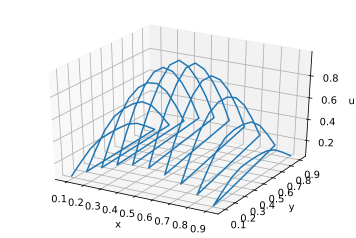

In [96]:
#Define parameters
n = 10
h = 1/(n+1) #step size

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define tridiagonal matrix T
diagonals = [[-2],[1],[1]]


#Compute exact solution for comparison
U_exact = np.sin(np.pi*X) * np.sin(np.pi*Y)

def monteCarlo(r1, r2, M):

    #Define mean, variance and solutions as zero matrices
    mean_sol = np.zeros([n,n])
    var_sol = np.zeros([n,n])
    sols = np.zeros([M,n,n])
        
    for i in range(0, M): 
        eps = random.uniform(r1, r2) #Generate random eps in range(r1,r2)
        T = np.multiply((-eps)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
        F = (2*(np.pi**2)*eps*np.sin(np.pi*X)*np.sin(np.pi*Y))+(34*(np.pi**2)*(eps**2)*np.sin(3*np.pi*X)*np.sin(5*np.pi*Y))
        U = sim_trans_explicit(T, F)[0]
        sols[i] = U
        mean_sol += U
        
    mean_sol = mean_sol/M #Divide by number of samples to get the mean solution
    plot_sol(X,Y,mean_sol)
    
    #Calculate variance
    for i in range(0, M):
        var_sol += ((sols[i] - mean_sol)**2)
        var_sol = var_sol/(M-1)
        
    err_inf, err_sq = compute_err(mean_sol, U_exact)
    print(err_inf, err_sq)
    

monteCarlo(-1,1,1)
monteCarlo(-1,1,10)
monteCarlo(-1,1,100)
monteCarlo(-1,1,1000)
monteCarlo(-1,1,10000)








## Adding more parameters
Let $\varepsilon = \varepsilon_0 + \sum_{ij}^N \varepsilon_{ij} \sin(i \pi x) \sin (j \pi y)$, where $\varepsilon_{ij} \sim u \left(-2^{- \sqrt{i^2 + j^2}}, 2^{- \sqrt{i^2 + j^2}} \right)$

In [6]:
#Define parameters
n = 125
h = 1/(n+1) #step size

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define tridiagonal matrix T
diagonals = [[-2],[1],[1]]

#Compute exact solution for comparison
U_exact = np.sin(np.pi*X) * np.sin(np.pi*Y)

def monteCarlo(M):
    N = 1 #defines number of random variables excluding eps0

    #Define mean, variance and solutions as zero matrices
    mean_sol = np.zeros([n,n])
    var_sol = np.zeros([n,n])
    sols = np.zeros([M,n,n])
        
    for m in range(0, M):
        T = np.multiply((-1)/(h**2), diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())
        F = 2*(np.pi**2)*np.sin(np.pi*X)*np.sin(np.pi*Y)
        eps0 = np.random.uniform(-1,1,1) + 2
        eps = np.zeros([N,N])
        for p in range(0,N):
            for q in range(0,N):
                lower = -2**(-np.sqrt(p**2 + q**2))
                upper = 2**(-np.sqrt(p**2 + q**2))
                eps[p][q] = np.random.uniform(lower,upper,1)
        for i in range(0,n):
            for j in range(0,n):
                sum1 = 0
                sum2 = eps0
                for p in range(0,N):
                    for q in range(0,N):
                        sum1 += eps[p][q]*(p**2 + q**2)*np.sin(p*np.pi*X[i][j])*np.sin(q*np.pi*Y[i][j])
                        sum2 += eps[p][q]*np.sin(p*np.pi*X[i][j])*np.sin(q*np.pi*Y[i][j])
                F[i][j] = (F[i][j] + sum1)*(sum2)
                T[i][j] = T[i][j]*sum2
        
        U = sim_trans_explicit(T, F)[0]
        sols[m] = U
        mean_sol += U
        
    mean_sol = mean_sol/M #Divide by number of samples to get the mean solution
    
    #Calculate variance
#     for m in range(0, M):
#         var_sol += ((sols[m] - mean_sol)**2)
#         var_sol = var_sol/(M-1)
        
    err_inf, err_sq = compute_err(mean_sol, U_exact)
    print(err_inf, err_sq)
        
    return mean_sol

M = 1
U = monteCarlo(M)

5.1807294055628006e-05 2.5903647025028362e-05


## Monte Carlo, multiple parameters for SSH

In [49]:
b

KeyboardInterrupt: 

## Results: N=1
- 5.180729403209128e-05 2.5903647013178544e-05, M=1, n=125
- 1.3054415694546684e-05 6.527463476953351e-06, M=4, n=250
- 3.2767245228271236e-06 1.6383783171672033e-06, M=16, n=500
